In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve as lk
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile

In [2]:
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

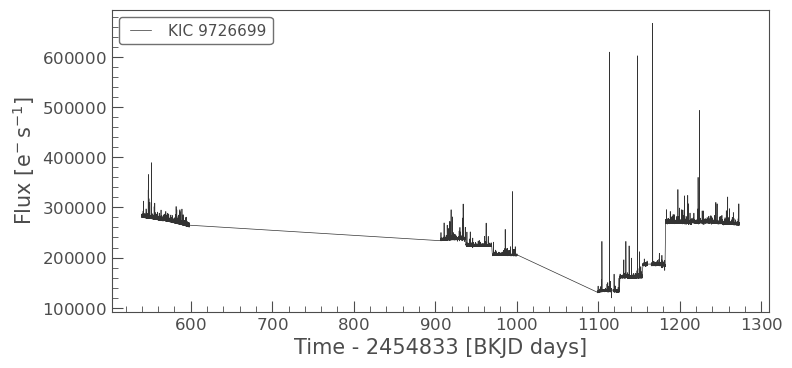

In [3]:
gj1243lc.plot()

Importing in a few flare stars from short cadence TESS data

In [4]:
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename

In [5]:
fs1 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020294194027-s0031-0000000197829751-0198-a_fast-lc.fits')
fs2 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020266004630-s0030-0000000201898220-0195-a_fast-lc.fits')
fs3 = get_pkg_data_filename('/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020351194500-s0033-0000000272232401-0203-a_fast-lc.fits')

In [6]:
fs1

'/Users/lupitatovar/local_flares/TESS_Flare_Stars/tess2020294194027-s0031-0000000197829751-0198-a_fast-lc.fits'

In [7]:
lc1 = TimeSeries.read(fs1,format='tess.fits')
lc2 = TimeSeries.read(fs2,format='tess.fits')
lc3 = TimeSeries.read(fs3,format='tess.fits')

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6045 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 4590 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 6750 rows with NaN times
  warnings.warn('Ignoring {} rows with NaN times'.format(np.sum(nans)))


In [29]:
#lc1['time', 'sap_flux']
lc1.time.mjd

array([59144.00942617, 59144.00965765, 59144.00988913, ...,
       59169.44652103, 59169.44675251, 59169.44698399])

Text(0, 0.5, 'SAP Flux (e-/s)')

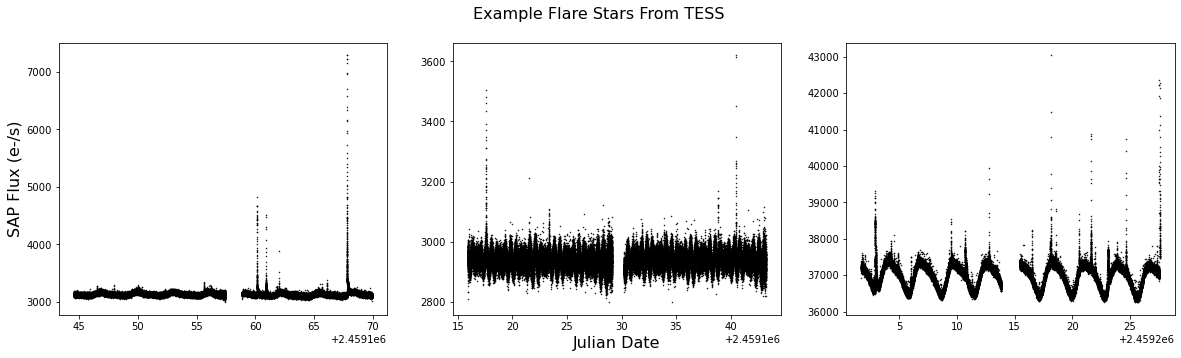

In [8]:
fig, axs = plt.subplots(1,3, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.suptitle('Example Flare Stars From TESS',fontsize='16')

axs[0].plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
axs[1].plot(lc2.time.jd, lc2['sap_flux'], 'k.', markersize=1)
axs[2].plot(lc3.time.jd, lc3['sap_flux'], 'k.', markersize=1)


axs[1].set_xlabel('Julian Date',fontsize='16')
axs[0].set_ylabel('SAP Flux (e-/s)',fontsize='16')

In [9]:
from scipy import special
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

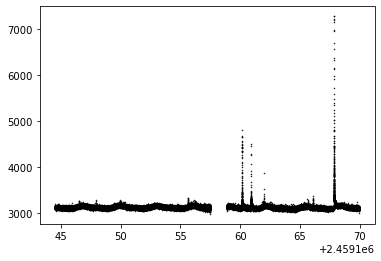

In [17]:
plt.plot(lc1.time.jd, lc1['sap_flux'], 'k.', markersize=1)
#plt.xlim(2.65e6,2.70e6)